In [1]:
%cd '/content/drive/MyDrive/Cov19/input/'

/content/drive/.shortcut-targets-by-id/156/Cov19/input


In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import os as os
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm.notebook as tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology as morph
from skimage import measure

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading Data

In [4]:
infile = open('Processed_Data.cp','rb')
data_dict = pickle.load(infile)
all_cts = data_dict['cts']
all_lungs = data_dict['lungs']
infile.close()

In [5]:
from sklearn.utils import shuffle
all_cts, all_lungs = shuffle(all_cts, all_lungs) #synchronized shuffling of data

In [6]:
print(all_cts.shape)
print(all_lungs.shape)

(1564, 128, 128, 1)
(1564, 128, 128, 1)


# Normalising the data 

In [7]:
all_cts = (all_cts - all_cts.min())/(all_cts.max()-all_cts.min())
all_lungs = (all_lungs - all_lungs.min())/(all_lungs.max()-all_lungs.min())

In [8]:
print("{} {}".format(all_cts.min(), all_cts.max()))
print("{} {}".format(all_lungs.min(), all_lungs.max()))

0.0 1.0
0.0 1.0


# Splitting the data

In [9]:
X_train = all_cts[:int(len(all_cts)*0.6)]
Y_train = all_lungs[:int(len(all_lungs)*0.6)]
X_val = all_cts[int(len(all_cts)*0.6):int(len(all_cts)*0.8)]
Y_val = all_lungs[int(len(all_lungs)*0.6):int(len(all_lungs)*0.8)]
X_test = all_cts[int(len(all_cts)*0.8):]
Y_test = all_lungs[int(len(all_lungs)*0.8):]

In [10]:
print("{} {}".format(X_train.shape, Y_train.shape))
print("{} {}".format(X_val.shape, Y_val.shape))
print("{} {}".format(X_test.shape, Y_test.shape))

(938, 128, 128, 1) (938, 128, 128, 1)
(313, 128, 128, 1) (313, 128, 128, 1)
(313, 128, 128, 1) (313, 128, 128, 1)


# Defining loss and accuracy functions

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [12]:
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


# Defining the U-Net Model

In [13]:
def build_model():
    num_filters=[16,32,128,256]
    inputs = Input((128, 128, 1))
    x = Conv2D(num_filters[0], kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[1], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[2], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[3], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Dense(num_filters[3], activation='relu')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[3], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[2], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[1], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    lung_seg = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(x) # identifying lungs

    model = Model(inputs=inputs, outputs=lung_seg, name='lung_seg')

    return model
model = build_model()
model.summary()

Model: "lung_seg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0  

# Compiling the model 

In [14]:
initial_learning_rate = 0.0001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss=dice_coef_loss,
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    metrics=[dice_coef],
)
checkpoint_cb = callbacks.ModelCheckpoint(
    "3d_image_segmentation.h5", save_best_only=True
)

# Training the model

In [15]:
history = model.fit(X_train, Y_train, epochs = 100, validation_data = (X_val, Y_val), callbacks = [checkpoint_cb],  shuffle=True, verbose=1)

Epoch 1/100
30/30 [==============================] - 9s 56ms/step - loss: -0.3798 - dice_coef: 0.3798 - val_loss: -0.4385 - val_dice_coef: 0.4380
Epoch 2/100
30/30 [==============================] - 1s 31ms/step - loss: -0.4369 - dice_coef: 0.4368 - val_loss: -0.4424 - val_dice_coef: 0.4420
Epoch 3/100
30/30 [==============================] - 1s 31ms/step - loss: -0.4364 - dice_coef: 0.4365 - val_loss: -0.4439 - val_dice_coef: 0.4435
Epoch 4/100
30/30 [==============================] - 1s 31ms/step - loss: -0.4431 - dice_coef: 0.4431 - val_loss: -0.4450 - val_dice_coef: 0.4446
Epoch 5/100
30/30 [==============================] - 1s 31ms/step - loss: -0.4398 - dice_coef: 0.4398 - val_loss: -0.4460 - val_dice_coef: 0.4455
Epoch 6/100
30/30 [==============================] - 1s 31ms/step - loss: -0.4422 - dice_coef: 0.4422 - val_loss: -0.4487 - val_dice_coef: 0.4482
Epoch 7/100
30/30 [==============================] - 1s 31ms/step - loss: -0.4450 - dice_coef: 0.4450 - val_loss: -0.4647 - 

# Plotting performance graphs

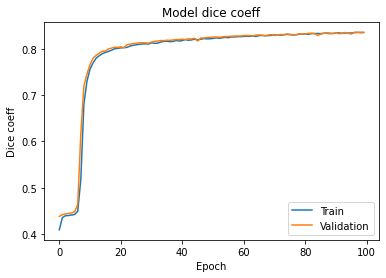

In [16]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Predicting the results for test data

In [17]:
model.load_weights('3d_image_segmentation.h5')
prediction = model.predict(X_test)

# Output Visualisation

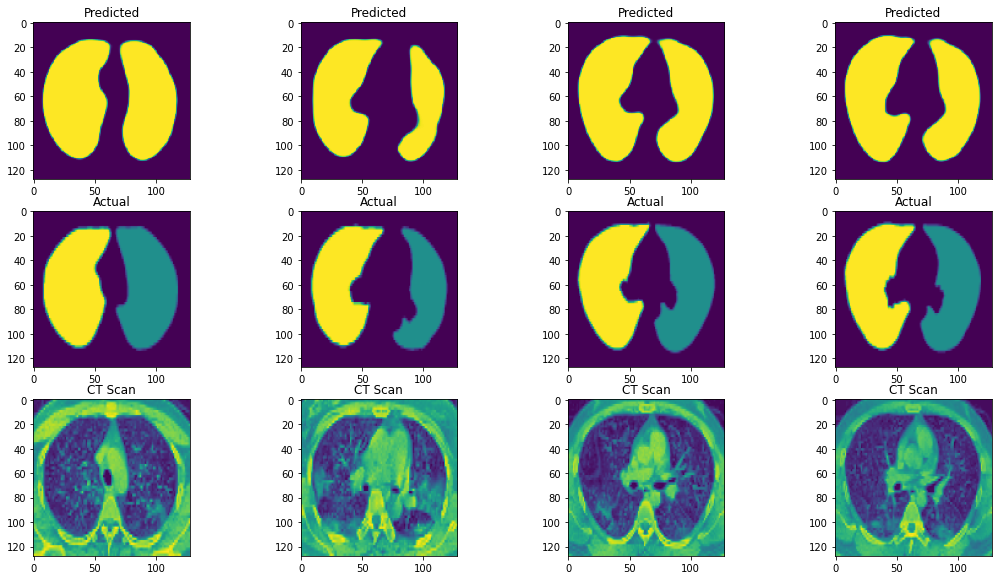

In [24]:
import random
fig, axes = plt.subplots(3, 4, figsize=(15,8))
fig.tight_layout()
for i in range(4):
    c = random.randint(0,prediction.shape[0]-1)
    axes[0,i].imshow(np.squeeze(prediction[c]))
    axes[0,i].set_title('Predicted')
    axes[1,i].imshow(np.squeeze(Y_test[c]))
    axes[1,i].set_title('Actual')
    axes[2,i].imshow(np.squeeze(X_test[c]))
    axes[2,i].set_title('CT Scan')
